# Load libraries and data

In [22]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.datasets import load_iris
import lightgbm as lgb
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_score

In [23]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
train_df = pd.read_csv('/content/drive/MyDrive/train_data_processed.csv')
test_df = pd.read_csv('/content/drive/MyDrive/test_data_processed.csv')

In [25]:
X = train_df.drop('isFraud', axis=1)
y = train_df['isFraud']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Train simple base model

In [26]:
clf = lgb.LGBMClassifier(random_state=50)
clf.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 14464, number of negative: 398912
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.770315 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 17068
[LightGBM] [Info] Number of data points in the train set: 413376, number of used features: 205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.034990 -> initscore=-3.317078
[LightGBM] [Info] Start training from score -3.317078


LGBMClassifier(random_state=50)

## Results analysis

In [27]:
y_pred_train = clf.predict(X_train)
y_pred_val = clf.predict(X_val)

print(f'Train accuracy: {round(accuracy_score(y_train, y_pred_train), 4)}')
print(f'Validation accuracy: {round(accuracy_score(y_val, y_pred_val), 4)}')

Train accuracy: 0.9786
Validation accuracy: 0.9774


In [28]:
print(f'Classification report: \n\n{classification_report(y_val, y_pred_val, digits=4)}')

Classification report: 

              precision    recall  f1-score   support

           0     0.9790    0.9980    0.9884    170963
           1     0.8814    0.4089    0.5587      6199

    accuracy                         0.9774    177162
   macro avg     0.9302    0.7035    0.7735    177162
weighted avg     0.9756    0.9774    0.9734    177162



Validation AUC: 0.9259


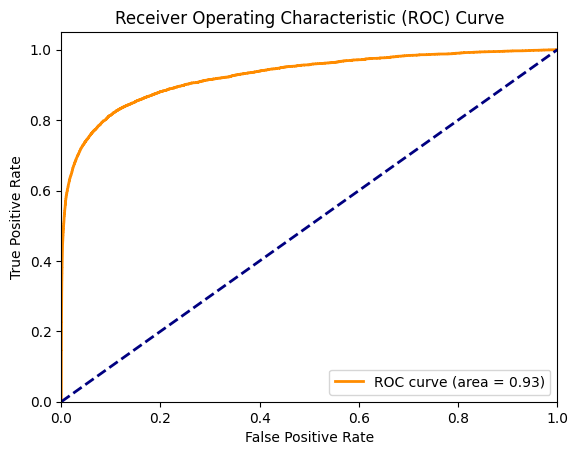

In [29]:
val_proba = clf.predict_proba(X_val)[:, 1]

fpr, tpr, thresholds = roc_curve(y_val, val_proba)
roc_auc = auc(fpr, tpr)

print(f"Validation AUC: {round(roc_auc, 4)}")

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


## Most important features

Top 25 Feature ranking:

1. card1 (182)
2. LogTransactionAmt (164)
3. card2 (153)
4. addr1 (122)
5. C13 (118)
6. D1 (102)
7. P_emaildomain_freq (84)
8. D15 (74)
9. D4 (69)
10. C1 (69)
11. C2 (65)
12. card5 (64)
13. C14 (63)
14. C11 (58)
15. C6 (57)
16. card3 (54)
17. D10 (49)
18. C9 (43)
19. Transaction_hour (42)
20. card6_debit (39)
21. V87 (32)
22. C12 (31)
23. V310 (30)
24. V53 (28)
25. ProductCD_R (27)



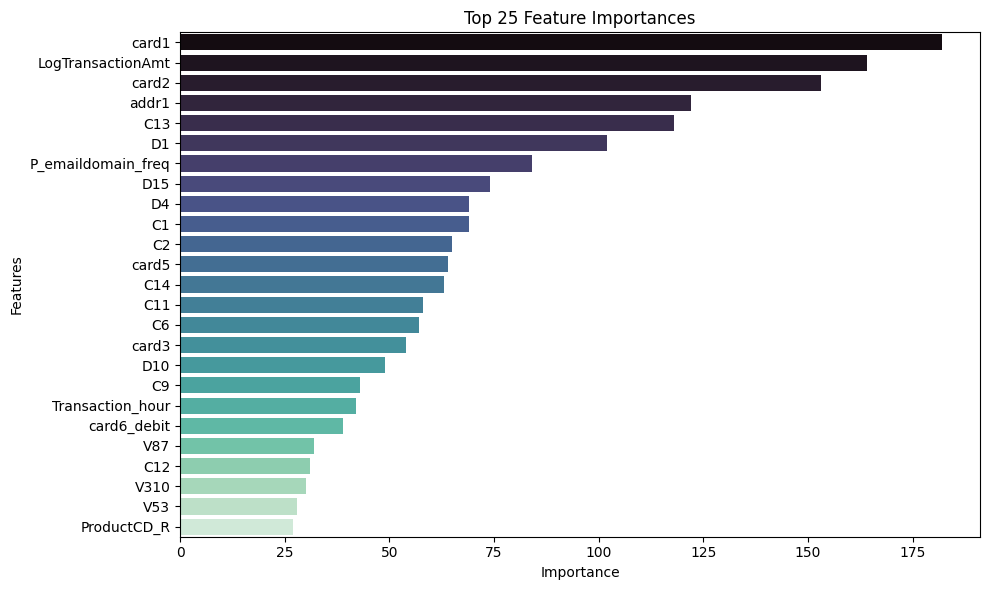

In [30]:
importances = clf.feature_importances_
feature_names = X_train.columns if hasattr(X_train, 'columns') else [f'Feature {i}' for i in range(X_train.shape[1])]
n_features = 25

indices = np.argsort(importances)[::-1][:n_features]

print(f"Top {n_features} Feature ranking:\n")
for i in range(len(indices)):
    print(f"{i + 1}. {feature_names[indices[i]]} ({importances[indices[i]]})")
print('')

top_features = [feature_names[i] for i in indices]
top_importances = importances[indices]

plt.figure(figsize=(10, 6))
sns.barplot(x=top_importances, y=top_features, palette="mako", legend=False, hue=top_features)
plt.title(f"Top {n_features} Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

In [31]:
X_important_train = X_train[top_features]
X_important_val = X_val[top_features]

In [32]:
clf = lgb.LGBMClassifier(random_state=50)
clf.fit(X_important_val, y_val)

[LightGBM] [Info] Number of positive: 6199, number of negative: 170963
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.208885 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4334
[LightGBM] [Info] Number of data points in the train set: 177162, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.034991 -> initscore=-3.317059
[LightGBM] [Info] Start training from score -3.317059


LGBMClassifier(random_state=50)

In [33]:
y_pred_train = clf.predict(X_important_train)
y_pred_val = clf.predict(X_important_val)

print(f'Train accuracy: {round(accuracy_score(y_train, y_pred_train), 4)}')
print(f'Validation accuracy: {round(accuracy_score(y_val, y_pred_val), 4)}')

Train accuracy: 0.9765
Validation accuracy: 0.9783


In [34]:
y_pred_val = clf.predict(X_important_val)

print(classification_report(y_val, y_pred_val))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99    170963
           1       0.90      0.43      0.58      6199

    accuracy                           0.98    177162
   macro avg       0.94      0.71      0.78    177162
weighted avg       0.98      0.98      0.97    177162



In [35]:
print(f'Classification report: \n\n{classification_report(y_val, y_pred_val, digits=4)}')

Classification report: 

              precision    recall  f1-score   support

           0     0.9797    0.9983    0.9889    170963
           1     0.8992    0.4286    0.5805      6199

    accuracy                         0.9783    177162
   macro avg     0.9394    0.7134    0.7847    177162
weighted avg     0.9769    0.9783    0.9746    177162



Validation AUC: 0.9439


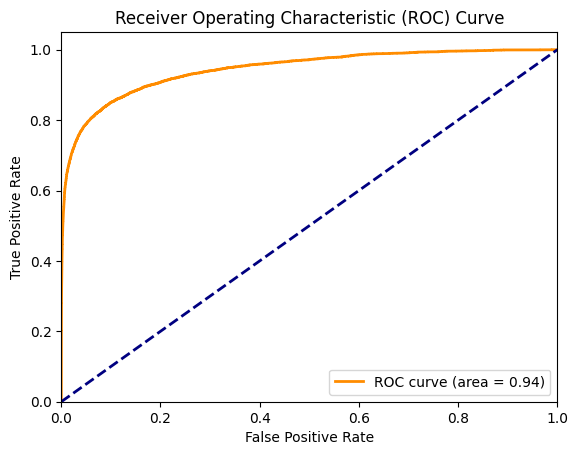

In [36]:
val_proba = clf.predict_proba(X_important_val)[:, 1]

fpr, tpr, thresholds = roc_curve(y_val, val_proba)
roc_auc = auc(fpr, tpr)

print(f"Validation AUC: {round(roc_auc, 4)}")

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


# Hyperparameter tuning

In [51]:
clf = lgb.LGBMClassifier(random_state=50)

param_grid = {
    'num_leaves': np.arange(20, 91, step=10),
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': np.arange(7, 19, step=3),
    'min_data_in_leaf': np.arange(20, 101, step=20),
    'feature_fraction': [0.7, 0.8, 0.9, 1.0]
}

random_search = RandomizedSearchCV(estimator=clf, param_distributions=param_grid, n_iter=20, cv=3, scoring='f1', verbose=3, random_state=50, n_jobs=-1)

random_search.fit(X_important_train, y_train)

print("Best parameters found: ", random_search.best_params_)
print("Best F1 score: ", random_search.best_score_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Info] Number of positive: 14464, number of negative: 398912
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.100102 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4344
[LightGBM] [Info] Number of data points in the train set: 413376, number of used features: 25
[LightGBM] [Info] [bi

In [52]:
best_params = random_search.best_params_

best_clf = lgb.LGBMClassifier(**best_params, random_state=50)
best_clf.fit(X_important_val, y_val)

scores = cross_val_score(best_clf, X_important_val, y_val, cv=3, scoring='f1')
print("F1 scores from cross-validation: ", scores)
print("Mean F1 score: ", scores.mean())

[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Info] Number of positive: 6199, number of negative: 170963
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.038244 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4334
[LightGBM] [Info] Number of data points in the train set: 177162, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.034991 -> initscore=-3.317059
[Li

In [53]:
y_pred_train = best_clf.predict(X_important_train)
y_pred_val = best_clf.predict(X_important_val)

print(f'Train accuracy: {round(accuracy_score(y_train, y_pred_train), 4)}')
print(f'Validation accuracy: {round(accuracy_score(y_val, y_pred_val), 4)}')

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
Train accuracy: 0.9782
Validation accuracy: 0.9821


In [54]:
print(f'Classification report: \n\n{classification_report(y_val, y_pred_val, digits=4)}')

Classification report: 

              precision    recall  f1-score   support

           0     0.9830    0.9987    0.9908    170963
           1     0.9372    0.5249    0.6729      6199

    accuracy                         0.9821    177162
   macro avg     0.9601    0.7618    0.8319    177162
weighted avg     0.9814    0.9821    0.9797    177162



[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
Validation AUC: 0.9698


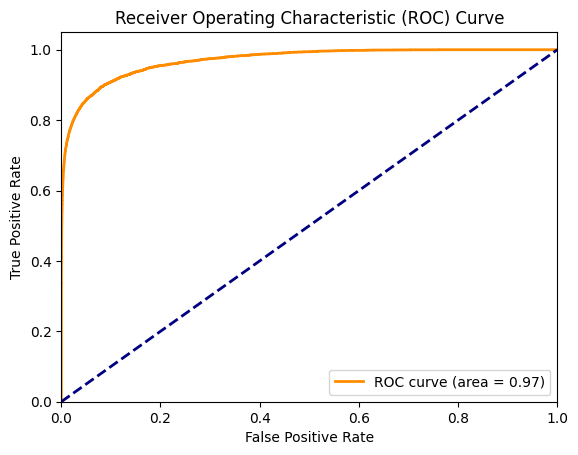

In [55]:
val_proba = best_clf.predict_proba(X_important_val)[:, 1]

fpr, tpr, thresholds = roc_curve(y_val, val_proba)
roc_auc = auc(fpr, tpr)

print(f"Validation AUC: {round(roc_auc, 4)}")

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


In [56]:
X_test = test_df[top_features + ['TransactionID']]
test_predictions = best_clf.predict_proba(X_test.drop(columns=['TransactionID']))[:, 1]

# Create the submission DataFrame
submission = pd.DataFrame({
    'TransactionID': X_test['TransactionID'],
    'isFraud': test_predictions
})

# Save the submission DataFrame to a CSV file
submission.to_csv('submission_lightgbm.csv', index=False)

print("Submission file created successfully!")

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
Submission file created successfully!
